In [19]:
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
import os

# Adjust the path as needed
data_path = '../../data/nifty/train/featured.csv'
df = pd.read_csv(data_path)

# Ensure date is datetime and sort
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

In [20]:
# -----------------------------
# SIMPLE PER-BAR TREND (Dow Theory)
# -----------------------------
prev_high = df['high'].shift(1)
prev_low = df['low'].shift(1)
prev_close = df['close'].shift(1)

higher_high = df['high'] > prev_high
lower_low = df['low'] < prev_low
close_up = df['close'] > prev_close
close_down = df['close'] < prev_close

is_up = higher_high & close_up
is_down = lower_low & close_down

trend_spec = pd.Series('Sideways', index=df.index)
trend_spec[is_up] = 'Uptrend'
trend_spec[is_down] = 'Downtrend'

df['dow_trend_spec_raw'] = trend_spec
df['dow_trend_spec'] = trend_spec.replace('Sideways', np.nan).ffill().fillna('Sideways')

# -----------------------------
# MOTHER CANDLE LOGIC
# -----------------------------
df['range'] = df['high'] - df['low']
df['avg_range'] = df['range'].rolling(window=20, min_periods=1).mean()
df['is_mother_candle'] = df['range'] > 1.1 * df['avg_range']

mother_candle_high = None
mother_candle_low = None
trend = 'Sideways'
mother_trend_list = []

for i in range(len(df)):
    if df.loc[i, 'is_mother_candle']:
        mother_candle_high = df.loc[i, 'high']
        mother_candle_low = df.loc[i, 'low']
        trend = 'Sideways'
    elif mother_candle_high and df.loc[i, 'close'] > mother_candle_high:
        trend = 'Uptrend'
    elif mother_candle_low and df.loc[i, 'close'] < mother_candle_low:
        trend = 'Downtrend'

    mother_trend_list.append(trend)

df['mother_candle_trend'] = mother_trend_list

# -----------------------------
# COMBINE BOTH LOGICS
# -----------------------------
df['final_trend'] = np.where(
    df['dow_trend_spec_raw'].isin(['Uptrend', 'Downtrend']),
    df['dow_trend_spec_raw'],
    df['mother_candle_trend']
)

import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Example
df['final_trend'] = df['final_trend'].astype(str)

# Encode
encoder = LabelEncoder()
df['trend_code'] = encoder.fit_transform(df['final_trend'])
# downtrend = 0, uptrend = 1, sideways = 2

print(encoder.classes_)
print(df[['dow_trend_spec', 'trend_code']].head())

# -----------------------------
# VIEW FULL DATAFRAME
# -----------------------------
display_cols = ['date', 'open', 'high', 'low', 'close', 'dow_trend_spec_raw', 
                'mother_candle_trend', 'final_trend', 'trend_code','range', 'avg_range', 'is_mother_candle']

print(df[display_cols].to_string(index=False))

['Downtrend' 'Sideways' 'Uptrend']
  dow_trend_spec  trend_code
0       Sideways           1
1        Uptrend           2
2        Uptrend           2
3        Uptrend           2
4        Uptrend           1
                     date     open     high      low    close dow_trend_spec_raw mother_candle_trend final_trend  trend_code   range  avg_range  is_mother_candle
2001-01-01 00:00:00+05:30  1263.50  1276.15  1250.65  1254.30           Sideways            Sideways    Sideways           1   25.50  25.500000             False
2001-01-02 00:00:00+05:30  1254.25  1279.59  1248.55  1271.80            Uptrend            Sideways     Uptrend           2   31.04  28.270000             False
2001-01-03 00:00:00+05:30  1271.80  1293.55  1263.95  1291.25            Uptrend            Sideways     Uptrend           2   29.60  28.713333             False
2001-01-04 00:00:00+05:30  1291.30  1331.35  1291.30  1307.65            Uptrend            Sideways     Uptrend           2   40.05  31.547500

In [21]:
# -----------------------------
# SELECT COLUMNS TO SAVE
# -----------------------------
candidate_cols_to_save = [
    'date', 'open', 'high', 'low', 'close', 'volume', 'final_trend', 'trend_code'
]

cols_present = [c for c in candidate_cols_to_save if c in df.columns]
df_to_save = df[cols_present].copy()

# -----------------------------
# SAVE CSV
# -----------------------------
output_path = '../../data/nifty/train/dow_theory_trend.csv'
df_to_save.to_csv(output_path, index=False)
print(f"Saved CSV with Mother Candle + Dow Theory trend: {output_path}")

# -----------------------------
# INSPECT TAIL FOR VERIFICATION
# -----------------------------
print("\n=== TAIL OF SAVED DATAFRAME ===\n")
print(df_to_save.tail(15).to_string(index=False))

# -----------------------------
# SAVE CSV
# -----------------------------
output_path = '../../data/nifty/train/full_featured.csv'
df.to_csv(output_path, index=False)
print(f"Saved Full Featured CSV with Mother Candle + Dow Theory trend: {output_path}")

# -----------------------------
# INSPECT TAIL FOR VERIFICATION
# -----------------------------
print("\n=== TAIL OF SAVED DATAFRAME ===\n")
print(df.tail(15).to_string(index=False))


Saved CSV with Mother Candle + Dow Theory trend: ../../data/nifty/train/dow_theory_trend.csv

=== TAIL OF SAVED DATAFRAME ===

                     date     open     high      low    close  volume final_trend  trend_code
2025-10-10 00:00:00+05:30 25167.65 25330.75 25156.85 25285.35       0     Uptrend           2
2025-10-13 00:00:00+05:30 25177.30 25267.30 25152.30 25227.35       0   Downtrend           0
2025-10-14 00:00:00+05:30 25277.55 25310.35 25060.55 25145.50       0   Downtrend           0
2025-10-15 00:00:00+05:30 25181.95 25365.15 25159.35 25323.55       0     Uptrend           2
2025-10-16 00:00:00+05:30 25394.90 25625.40 25376.85 25585.30       0     Uptrend           2
2025-10-17 00:00:00+05:30 25546.85 25781.50 25508.60 25709.85       0     Uptrend           2
2025-10-20 00:00:00+05:30 25824.60 25926.20 25788.50 25843.15       0     Uptrend           2
2025-10-21 00:00:00+05:30 25901.20 25934.35 25825.80 25868.60       0     Uptrend           2
2025-10-23 00:00:00+05:30 2


=== DOTTED BASELINE + COLORED SEGMENTS ===



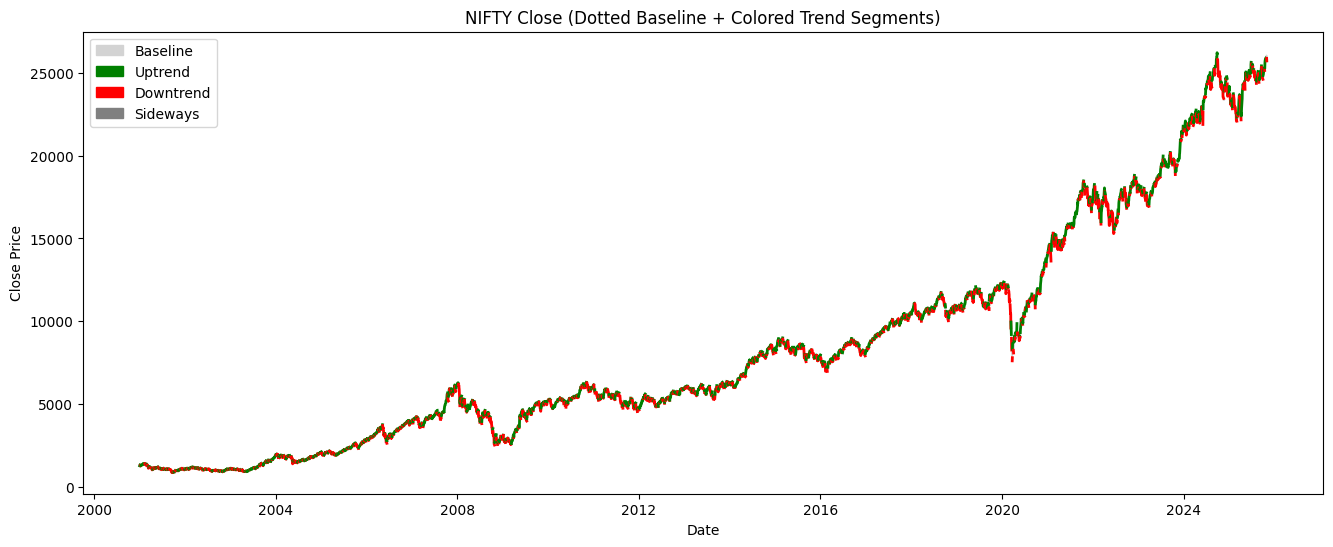

In [22]:
# DOTTED BASELINE + COLORED SEGMENTS (bridges gaps)
print("\n=== DOTTED BASELINE + COLORED SEGMENTS ===\n")

trend_col = 'dow_trend_spec'
if trend_col not in df.columns:
    raise ValueError(f"Missing trend column: {trend_col}")

run_id = (df[trend_col] != df[trend_col].shift(1)).cumsum()
trend_colors = {'Uptrend': 'green', 'Downtrend': 'red', 'Sideways': 'gray'}

plt.figure(figsize=(16,6))
# 1) Draw full series as dotted gray baseline
plt.plot(df['date'], df['close'], color='lightgray', linewidth=1.2, linestyle='--', label='Baseline')

# 2) Overlay colored contiguous segments
for rid, seg in df.groupby(run_id):
    t = seg[trend_col].iloc[0]
    color = trend_colors.get(t, 'black')
    plt.plot(seg['date'], seg['close'], color=color, linewidth=2)

plt.title('NIFTY Close (Dotted Baseline + Colored Trend Segments)')
plt.xlabel('Date')
plt.ylabel('Close Price')
import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=c, label=k) for k,c in trend_colors.items()]
handles.insert(0, mpatches.Patch(color='lightgray', label='Baseline'))
plt.legend(handles=handles)
plt.show()
